In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Load data

In [ ]:
df_train_path = '/kaggle/input/tabular-playground-series-jan-2022/train.csv'
df_test_path = '/kaggle/input/tabular-playground-series-jan-2022/test.csv'

df_train = pd.read_csv(df_train_path, index_col=0)
df_test = pd.read_csv(df_test_path, index_col=0)

In [ ]:
df_train.info()

In [ ]:
df_train.head()

In [ ]:
df_train.describe()

In [ ]:
df_train.isna().sum()

## Create features from 'date' column

In [ ]:
def create_time_features(df: pd.DataFrame) -> pd.DataFrame:
    
    df['date'] = pd.to_datetime(df['date'])
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month_name()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofmonth'] = df['date'].dt.days_in_month
    df['dayofyear'] = df['date'].dt.dayofyear.astype('int')
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int')
    df['weekday'] = df['date'].dt.weekday
    df['weekend'] = np.where((df['weekday'] == 5) | (df['weekday'] == 6), 1, 0)
    df['weekend'] = df['weekend']
    df['season'] = df['month']
    df['season'] = df['season'].replace(['January', 'February', 'December'], 'Winter')
    df['season'] = df['season'].replace(['March', 'April', 'May'], 'Spring')
    df['season'] = df['season'].replace(['June', 'July', 'August'], 'Summer')
    df['season'] = df['season'].replace(['September', 'October', 'November'], 'Autumn')
    
    return df

In [ ]:
df_train = create_time_features(df_train)
df_test = create_time_features(df_test)
df_train = df_train.set_index('date')
df_test = df_test.set_index('date')

## Create holiday features

Every feature created to each country

In [ ]:
import holidays

holiday_list = list()

for date in holidays.Finland(years=[2014, 2015, 2016, 2017, 2018, 2019, 2020]).items():
    holiday_list.append([date[0], date[1], "Finland"])
    
for date in holidays.Norway(years=[2014, 2015, 2016, 2017, 2018, 2019, 2020]).items():
    holiday_list.append([date[0], date[1], "Norway"])
    
for date in holidays.Sweden(years=[2014, 2015, 2016, 2017, 2018, 2019, 2020]).items():
    holiday_list.append([date[0], date[1], "Sweden"])

In [ ]:
holidays_df = pd.DataFrame(holiday_list, columns=['date_hol', 'holiday', 'country'])
holidays_df['date_hol'] = pd.to_datetime(holidays_df['date_hol'])
holidays_df = holidays_df.set_index('date_hol')
holidays_df = holidays_df.sort_index()

In [ ]:
def set_holiday(df):
    df.loc[df.index.isin(holidays_df[holidays_df['country']=='Sweden'].index) & (df['country'] == 'Sweden'), 'holiday'] = 1
    df.loc[df.index.isin(holidays_df[holidays_df['country']=='Finland'].index) & (df['country'] == 'Finland'), 'holiday'] = 1
    df.loc[df.index.isin(holidays_df[holidays_df['country']=='Norway'].index) & (df['country'] == 'Norway'), 'holiday'] = 1

    df['holiday'].fillna('0', inplace=True)
    df['holiday'] = df['holiday'].astype('int').astype('category')

In [ ]:
set_holiday(df_train)
set_holiday(df_test)

## Create number of days since last holiday and until next holiday

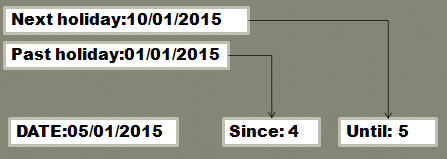

In [ ]:
# I think there could be a better way to create a features, if you found it, please inform

def create_days(country, dataframe):
    
    days = holidays_df[holidays_df['country'] == country].reset_index()[['date_hol']]
    df_days = dataframe[dataframe['country'] == country].reset_index()[['date']]

    df = pd.merge_asof(df_days, days, left_on='date', right_on='date_hol', direction='forward')
    df = pd.merge_asof(df, days, left_on='date', right_on='date_hol')
    df['until'] = df.pop('date_hol_x').sub(df['date']).dt.days
    df['since'] = df['date'].sub(df.pop('date_hol_y')).dt.days
    
    dataframe.loc[dataframe['country'] == country, ['until', 'since']] = df.set_index('date')[['until', 'since']]

In [ ]:
create_days('Finland', df_train)
create_days('Norway', df_train)
create_days('Sweden', df_train)

In [ ]:
create_days('Finland', df_test)
create_days('Norway', df_test)
create_days('Sweden', df_test)

## SMAPE

In [ ]:
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

## Pycaret

It's my first time of using it, so if you have any hints please inform me

In [ ]:
%%capture
!pip install pycaret[full]

In [ ]:
from pycaret.regression import *

reg = setup(data = df_train,
            target = 'num_sold',
            normalize = True, 
            normalize_method = 'robust', 
            transform_target = True, 
            data_split_shuffle = False, 
            create_clusters = True,
            feature_interaction = True,
            use_gpu = True,
            silent = True,
            n_jobs = -1)

In [ ]:
add_metric('SMAPE', 'SMAPE', SMAPE, greater_is_better = False)
N = 3
top = compare_models(sort = 'SMAPE', n_select = N)

In [ ]:
blend = blend_models(top)
predict_model(blend)

In [ ]:
final_blend = finalize_model(blend)
predict_model(final_blend)

In [ ]:
preds = predict_model(final_blend, data=df_test)
preds = preds['Label'].values
submit = pd.read_csv('/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv', index_col=0)
submit['num_sold'] = preds
submit.to_csv('submission.csv')